# Demo code to apply facial morphings

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import dlib
import pdb

from utils import applyAffineTransform, morphTriangle, extract_index_nparray, get_landmarks, delaunay_triangulation
from align_image import align_image
e2e = 150

(-0.5, 359.5, 449.5, -0.5)

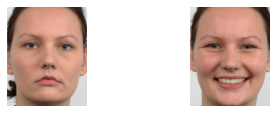

In [7]:
#Using dlib face detector and landmarks predictor  
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("./shape_predictor_68_face_landmarks.dat")

img_1_path  = r'C:\Users\Admin\Desktop\NUS\CS6101/Morphset/Original_data/R/Rafd090_08_Caucasian_female_neutral_frontal.jpg'
img_2_path = r'C:\Users\Admin\Desktop\NUS\CS6101/Morphset/Original_data/R/Rafd090_08_Caucasian_female_happy_frontal.jpg'

img1 = cv2.imread(img_1_path)
img2 = cv2.imread(img_2_path)

_, landmarks_points = get_landmarks(img1, detector, predictor)
_, landmarks_points2 = get_landmarks(img2, detector, predictor)

img1, points1 = align_image(landmarks_points, img1, e2e) 
img2, points2 = align_image(landmarks_points2, img2, e2e) 

plt.subplot(2,2,1)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)) #Source image
plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)) #Target image
plt.axis("off")

Apply morphing to obtain augmented images

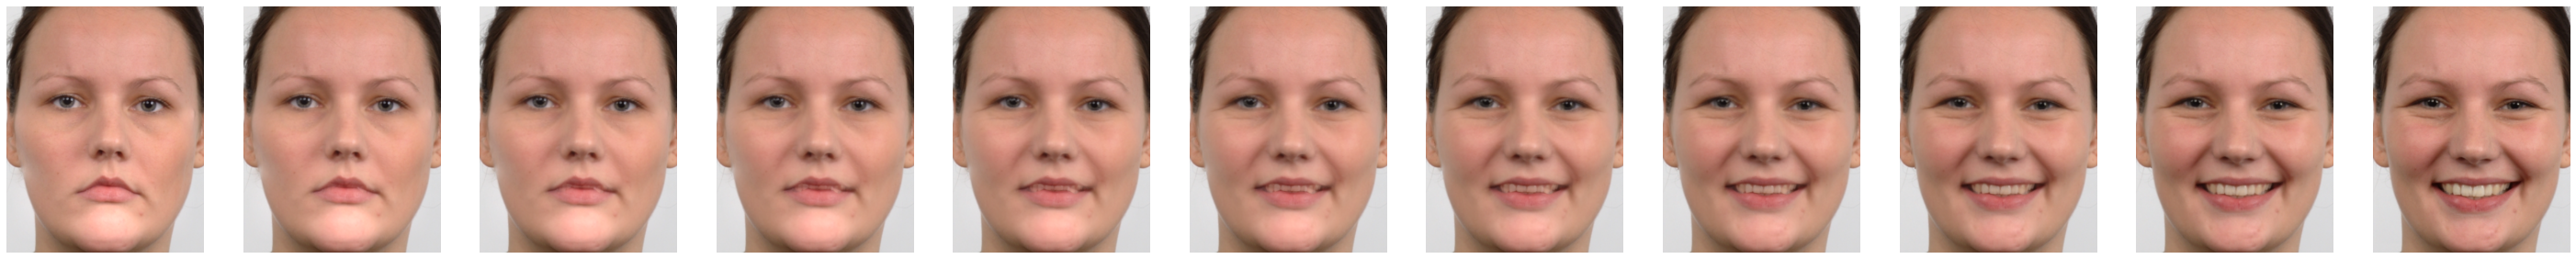

In [9]:
img2_gray = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
img2_face_mask = np.zeros_like(img2_gray)
img2_new_face = np.zeros_like(img2)

idx_triangles1 = delaunay_triangulation(points1)

N = 11
alpha_values = np.linspace(0,1,N)
f, axs = plt.subplots(1, N , figsize=(50,50) )

for count, alpha in enumerate(alpha_values):

    imgMorph = np.zeros(img1.shape, dtype = img1.dtype)

    # Compute weighted average point coordinates
    points = []
    for i in range(0, len(points1)):
        x = ( 1 - alpha ) * points1[i][0] + alpha * points2[i][0]
        y = ( 1 - alpha ) * points1[i][1] + alpha * points2[i][1]
        points.append((x,y))

    for v1, v2, v3 in idx_triangles1 :
                        
        t1 = [points1[v1], points1[v2], points1[v3]]
        t2 = [points2[v1], points2[v2], points2[v3]]
        t  = [ points[v1],  points[v2],  points[v3]]

        # Morph one triangle at a time.
        morphTriangle(img1, img2, imgMorph, t1, t2, t, alpha)


    img2_new_face_gray = cv2.cvtColor(imgMorph, cv2.COLOR_BGR2GRAY)
    _, background = cv2.threshold(img2_new_face_gray, 1, 255, cv2.THRESH_BINARY_INV)
    
    background = cv2.bitwise_and(img2, img2, mask=background)
    
    result = cv2.add(background, imgMorph)
    
    # perform seamless clone
    convexhull2 = cv2.convexHull(points1) #create outline from points
    img2_head_mask = cv2.fillConvexPoly(img2_face_mask, convexhull2, 255)
    (x3, y3, w3, h3) = cv2.boundingRect(convexhull2)

    center = (int((x3 + x3 + w3) / 2), int((y3 + y3 + h3) / 2))

    seamlessclone = cv2.seamlessClone(result, img2, img2_head_mask, (center), cv2.NORMAL_CLONE)
    seamlessclone = cv2.cvtColor(seamlessclone, cv2.COLOR_BGR2RGB)
    
    axs[count].imshow(seamlessclone)
    axs[count].axis("off")